In [28]:
import os
import sys
sys.path.append('/home/fruitspec-lab/FruitSpec/Code/fsCounter')
from omegaconf import OmegaConf
import pyzed.sl as sl
import cv2
import numpy as np
from scipy.stats import gaussian_kde
import kornia as K
from tqdm import tqdm
import numpy as np
import collections
import pandas as pd
from vision.misc.help_func import get_repo_dir, scale_dets, validate_output_path, scale
from vision.depth.zed.svo_operations import get_frame, get_depth, get_point_cloud, get_dimensions, sl_get_dimensions

repo_dir = get_repo_dir()
sys.path.append(os.path.join(repo_dir, 'vision', 'detector', 'yolo_x'))

from vision.pipelines.detection_flow import counter_detection
from vision.pipelines.misc.filters import filter_by_distance, filter_by_size, filter_by_height, sort_out
from vision.tracker.fsTracker.score_func import compute_dist_on_vec
from vision.data.results_collector import ResultsCollector
from vision.tools.translation import translation as T
from vision.tools.camera import is_sturated
from vision.tools.color import get_hue
from vision.tools.video_wrapper import video_wrapper
from vision.tools.image_stitching import plot_2_imgs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
repo_dir = get_repo_dir()
pipeline_config = "/home/fruitspec-lab/FruitSpec/Code/fsCounter/vision/pipelines/config/pipeline_config.yaml"
runtime_config = "/home/fruitspec-lab/FruitSpec/Code/fsCounter/vision/pipelines/config/runtime_config.yaml"
cfg = OmegaConf.load(pipeline_config)
args = OmegaConf.load(runtime_config)

validate_output_path(args.output_folder)

In [4]:
detector = counter_detection(cfg, args)
results_collector = ResultsCollector(rotate=args.rotate)
translation = T(cfg.translation.translation_size, cfg.translation.dets_only, cfg.translation.mode)

cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)

# Read until video is completed
print(f'Inferencing on {args.movie_path}\n')
number_of_frames = cam.get_number_of_frames()


loading checkpoint from /home/fruitspec-lab/FruitSpec/weights/Run_6_Dec_2022_1Class_aug_tasqV2/best_ckpt.pth
loaded checkpoint done.
Inferencing on /home/fruitspec-lab/Downloads/0.8m1sts/ZED_1.svo



In [8]:
measures_path = "/home/fruitspec-lab/Downloads/0.8m1sts/output/measures.csv"
measures_frame = pd.read_csv(measures_path)

In [5]:
def plot_image_grid(images, nrows, ncols, titles=None, figsize=None, xlabels=None, ylabels=None, cmap='viridis'):
    """
    Plots a grid of images using matplotlib.

    Parameters:
    images (list): A list of numpy arrays representing the images to be plotted.
    nrows (int): The number of rows in the grid.
    ncols (int): The number of columns in the grid.
    titles (list, optional): A list of strings representing the titles of the images. Must have the same length as images.
    figsize (tuple, optional): A tuple representing the size of the figure. Defaults to (ncols * 5, nrows * 5).
    xlabels (list, optional): A list of strings representing the x-axis labels for each image. Must have the same length as images.
    ylabels (list, optional): A list of strings representing the y-axis labels for each image. Must have the same length as images.
    cmap (str, optional): The color map to use when plotting the images. Defaults to 'viridis'.

    Returns:
    None
    """
    n_images = len(images)
    if isinstance(figsize, type(None)):
        figsize = (ncols * 5, nrows * 5)
    titles, xlabels, ylabels = (np.full(n_images, "") if isinstance(titles, type(None)) else arr
                                for arr in [titles, xlabels, ylabels])
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        image = images[i]
        ax.imshow(image)
        ax.set_title(titles[i])
        ax.set_xlabel(xlabels[i])
        ax.set_ylabel(ylabels[i])
    plt.tight_layout()
    plt.show()

def get_real_world_dims_with_correction(depth_map, fx = 1065.98388671875, fy = 1065.98388671875, resized = True):
    """
    calculates each pixel size based on trigo
    :param depth_map: distance_map to each point or an empty string
    :return: size for each pixel
    """
    pic_size = depth_map.shape
    if resized:
        resize_fator_x = 1080/pic_size[0]
        resize_fator_y = 1920/pic_size[1]
    else:
        resize_fator_x = 1
        resize_fator_y = 1
    x0 = pic_size[1] /2
    y0 = pic_size[0] /2
    pixel_mm = 0.002
    focal_len = (fx + fy) / 2 * pixel_mm
    x_range = np.arange(1, pic_size[1]+1)
    X_pix_dist_from_center = np.abs(np.array([x_range for i in range(pic_size[0])]) - x0)
    X_mm_dist_from_center = (X_pix_dist_from_center * (X_pix_dist_from_center+1)*(pixel_mm**2))
    beta = np.arctan(0.001/(focal_len + (X_mm_dist_from_center/focal_len)))
    gamma = np.arctan((X_pix_dist_from_center+1)*pixel_mm/focal_len)
    size_x = (np.tan(gamma) - np.tan(gamma-beta))*depth_map*2*resize_fator_x
    size_y = (np.tan(gamma) - np.tan(gamma-beta))*depth_map*2*resize_fator_y
    return size_x, size_y, size_x*size_y



In [6]:
def get_track_id_frames(measures_frame, track_id):
    """
    Returns a numpy array of frames associated with a given track ID.

    Parameters:
    measures_frame (pandas.DataFrame): A dataframe containing measurements data.
    track_id (int): The ID of the track to retrieve frames for.

    Returns:
    numpy.ndarray: A 1-dimensional array of frames associated with the given track ID.
    """
    return measures_frame[measures_frame["track_id"] == track_id]["frame"].values

def get_track_id_boxes(measures_frame, track_id):
    """
    Returns a numpy array of bounding boxes associated with a given track ID.

    Parameters:
    measures_frame (pandas.DataFrame): A dataframe containing measurements data.
    track_id (int): The ID of the track to retrieve bounding boxes for.

    Returns:
    numpy.ndarray: A 2-dimensional array of bounding boxes associated with the given track ID.
        Each row contains the x1, y1, x2, y2 coordinates of a bounding box in the format [x1, y1, x2, y2].
    """
    return measures_frame[measures_frame["track_id"] == track_id][["x1", "y1", "x2", "y2"]].values

def validate_bbox(crop, rgb_img):
    """
    Validates the given bounding box coordinates and ensures that they fall within the dimensions of the RGB image.

    Parameters:
    crop (tuple): A tuple containing the coordinates of the bounding box in the format (x1, y1, x2, y2).
        x1 and y1 are the coordinates of the top-left corner of the bounding box, and x2 and y2 are the coordinates of the bottom-right corner.
    rgb_img (numpy.ndarray): A numpy array representing the RGB image.

    Returns:
    tuple: A tuple containing the validated bounding box coordinates in the format (x1, y1, x2, y2).
        The returned coordinates ensure that the bounding box falls entirely within the dimensions of the RGB image.
    """
    x1, y1, x2, y2 = crop
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    h, w = rgb_img.shape[:2]
    x2 = min(x2, w-1)
    y2 = min(y2, h-1)
    return x1, y1, x2, y2


def get_track_id_images(measures_frame, track_id):
    frame_numbers = get_track_id_frames(measures_frame, track_id)
    boxes = get_track_id_boxes(measures_frame, track_id)
    rgb_images, pc_images = [], []
    for frame, crop in tqdm(zip(frame_numbers, boxes)):
        rgb_img, _, pc_img = cam.get_zed(frame)
        x1,y1,x2,y2 = validate_bbox(crop, rgb_img)
        rgb_images.append(rgb_img[y1:y2,x1:x2])
        pc_images.append(pc_img[y1:y2,x1:x2])
    return rgb_images, pc_images

In [8]:
# rgb_images, pc_images = get_track_id_images(measures_frame, 7)
# plot_2_imgs(rgb_images[0], pc_images[0][:,:,2])

6


107it [00:11,  9.23it/s]


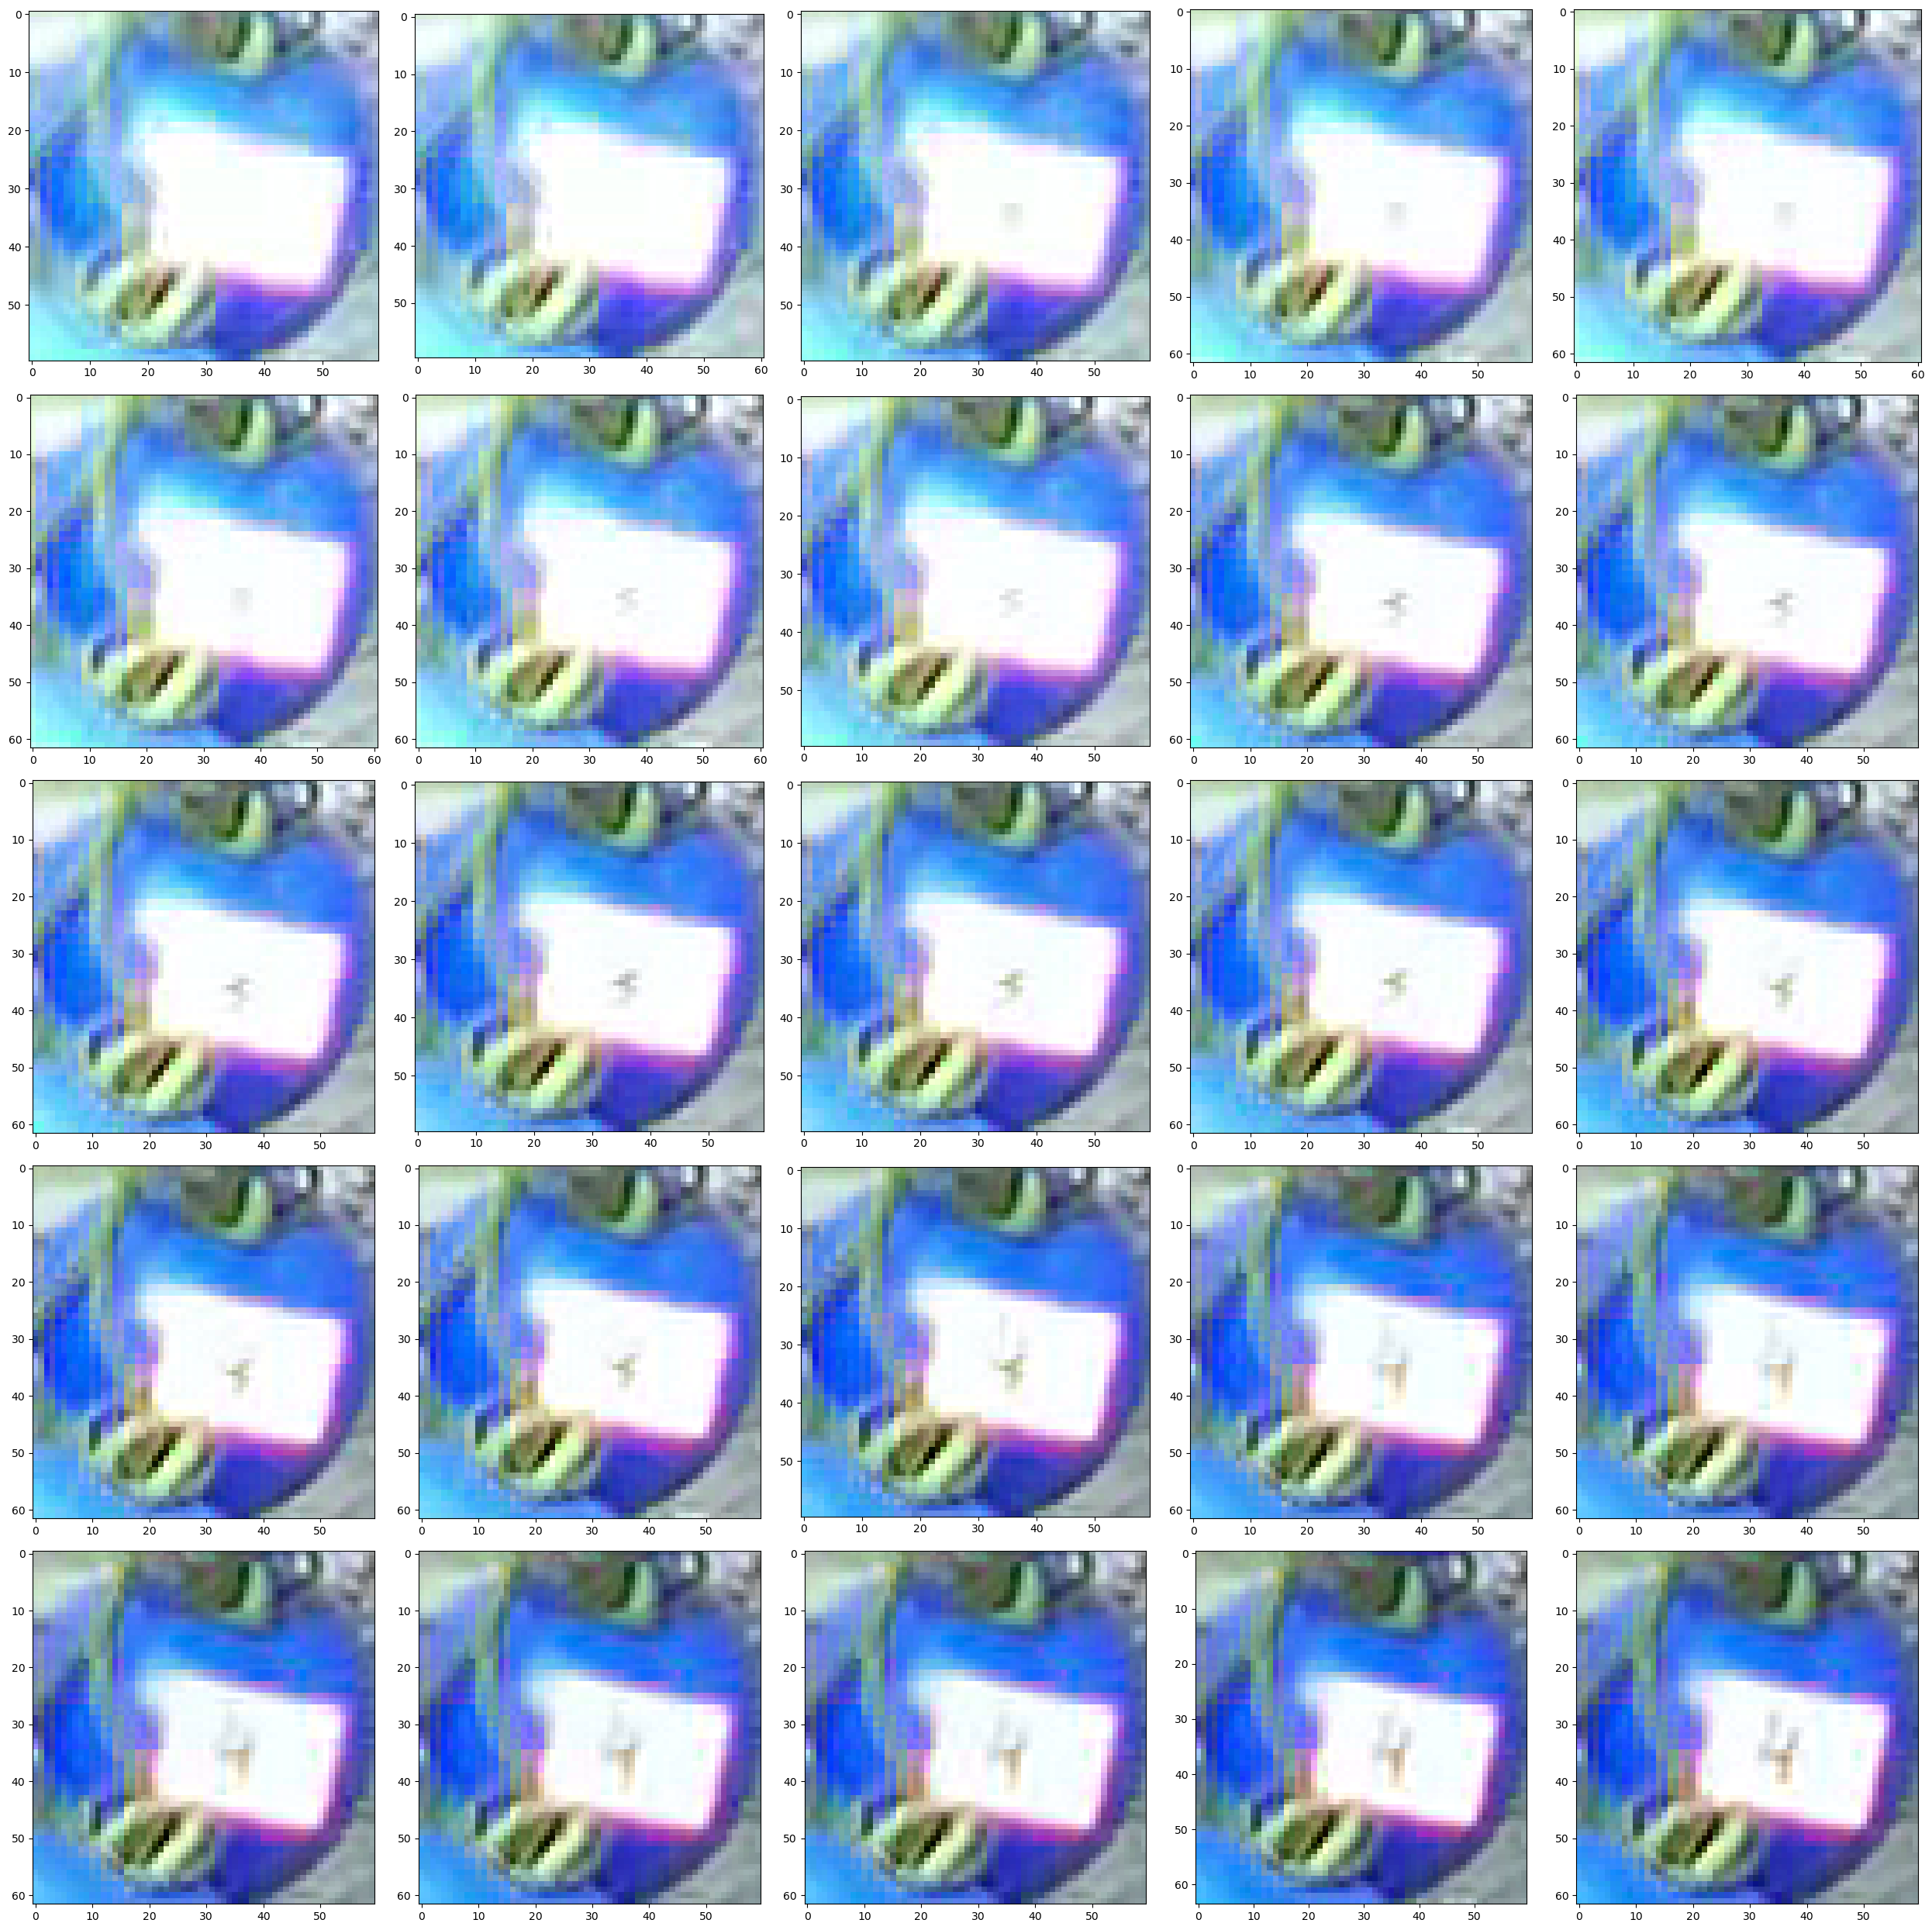

7


107it [00:11,  9.32it/s]


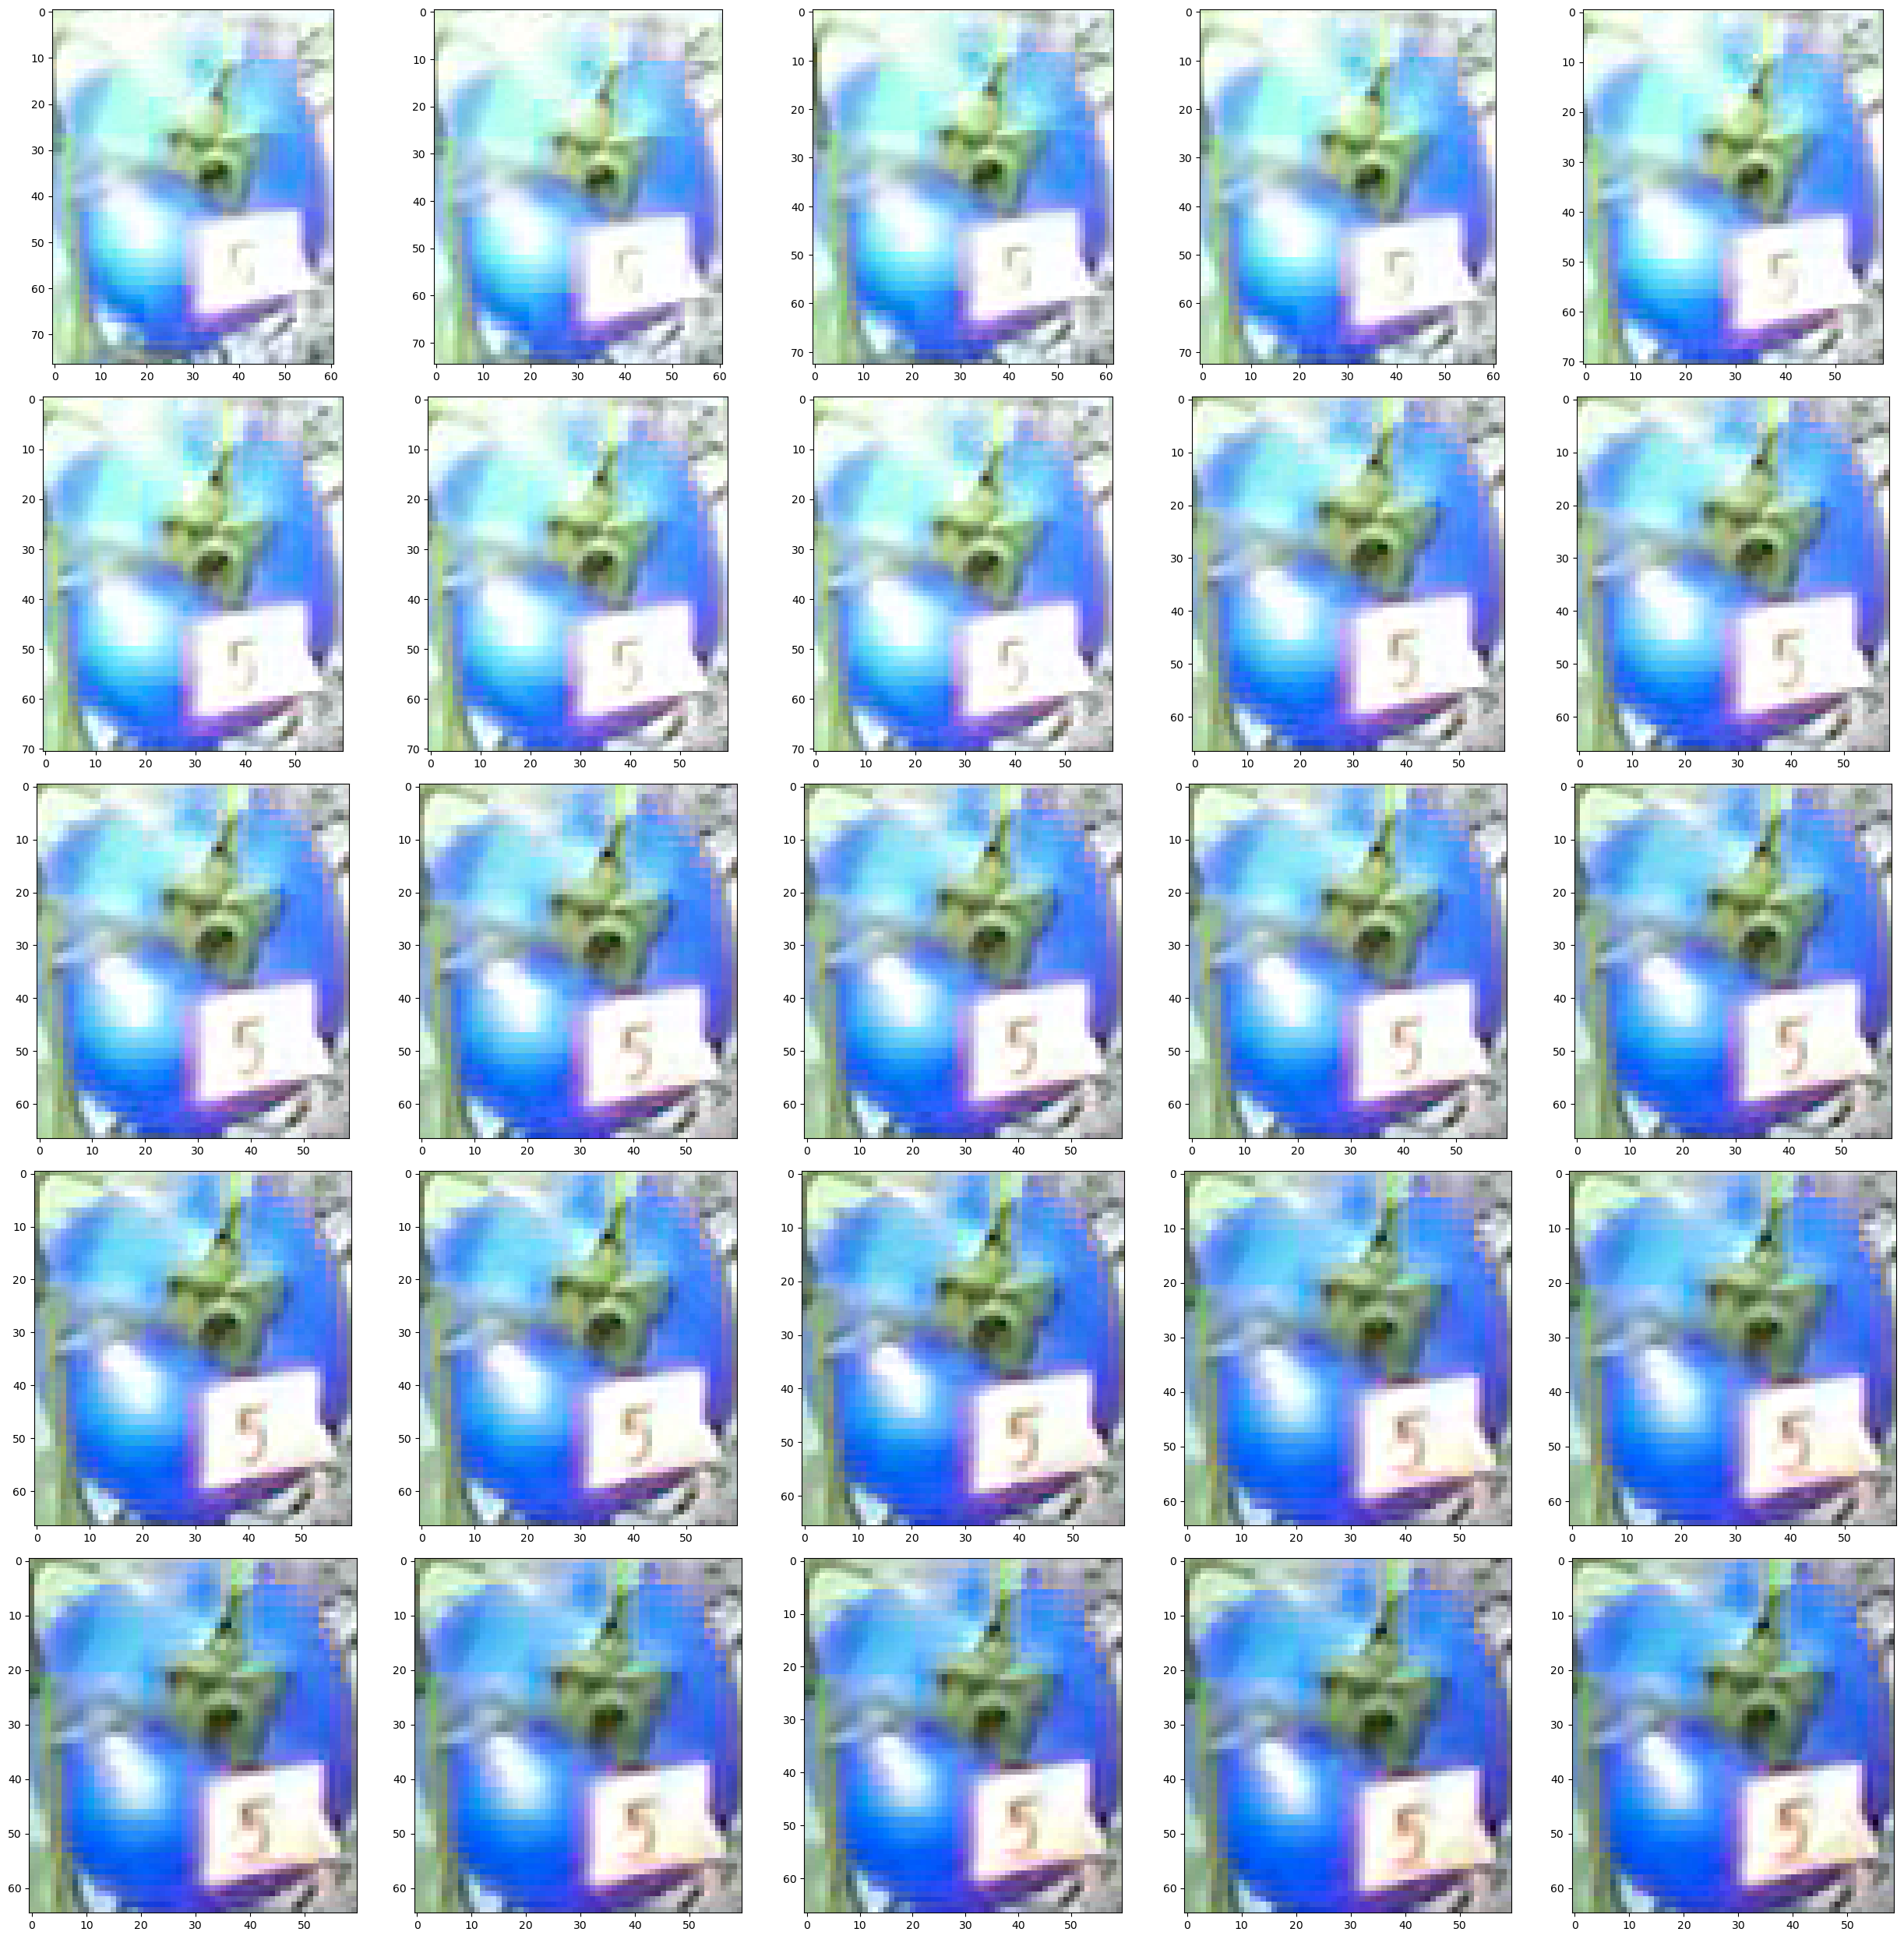

8


107it [00:11,  9.11it/s]


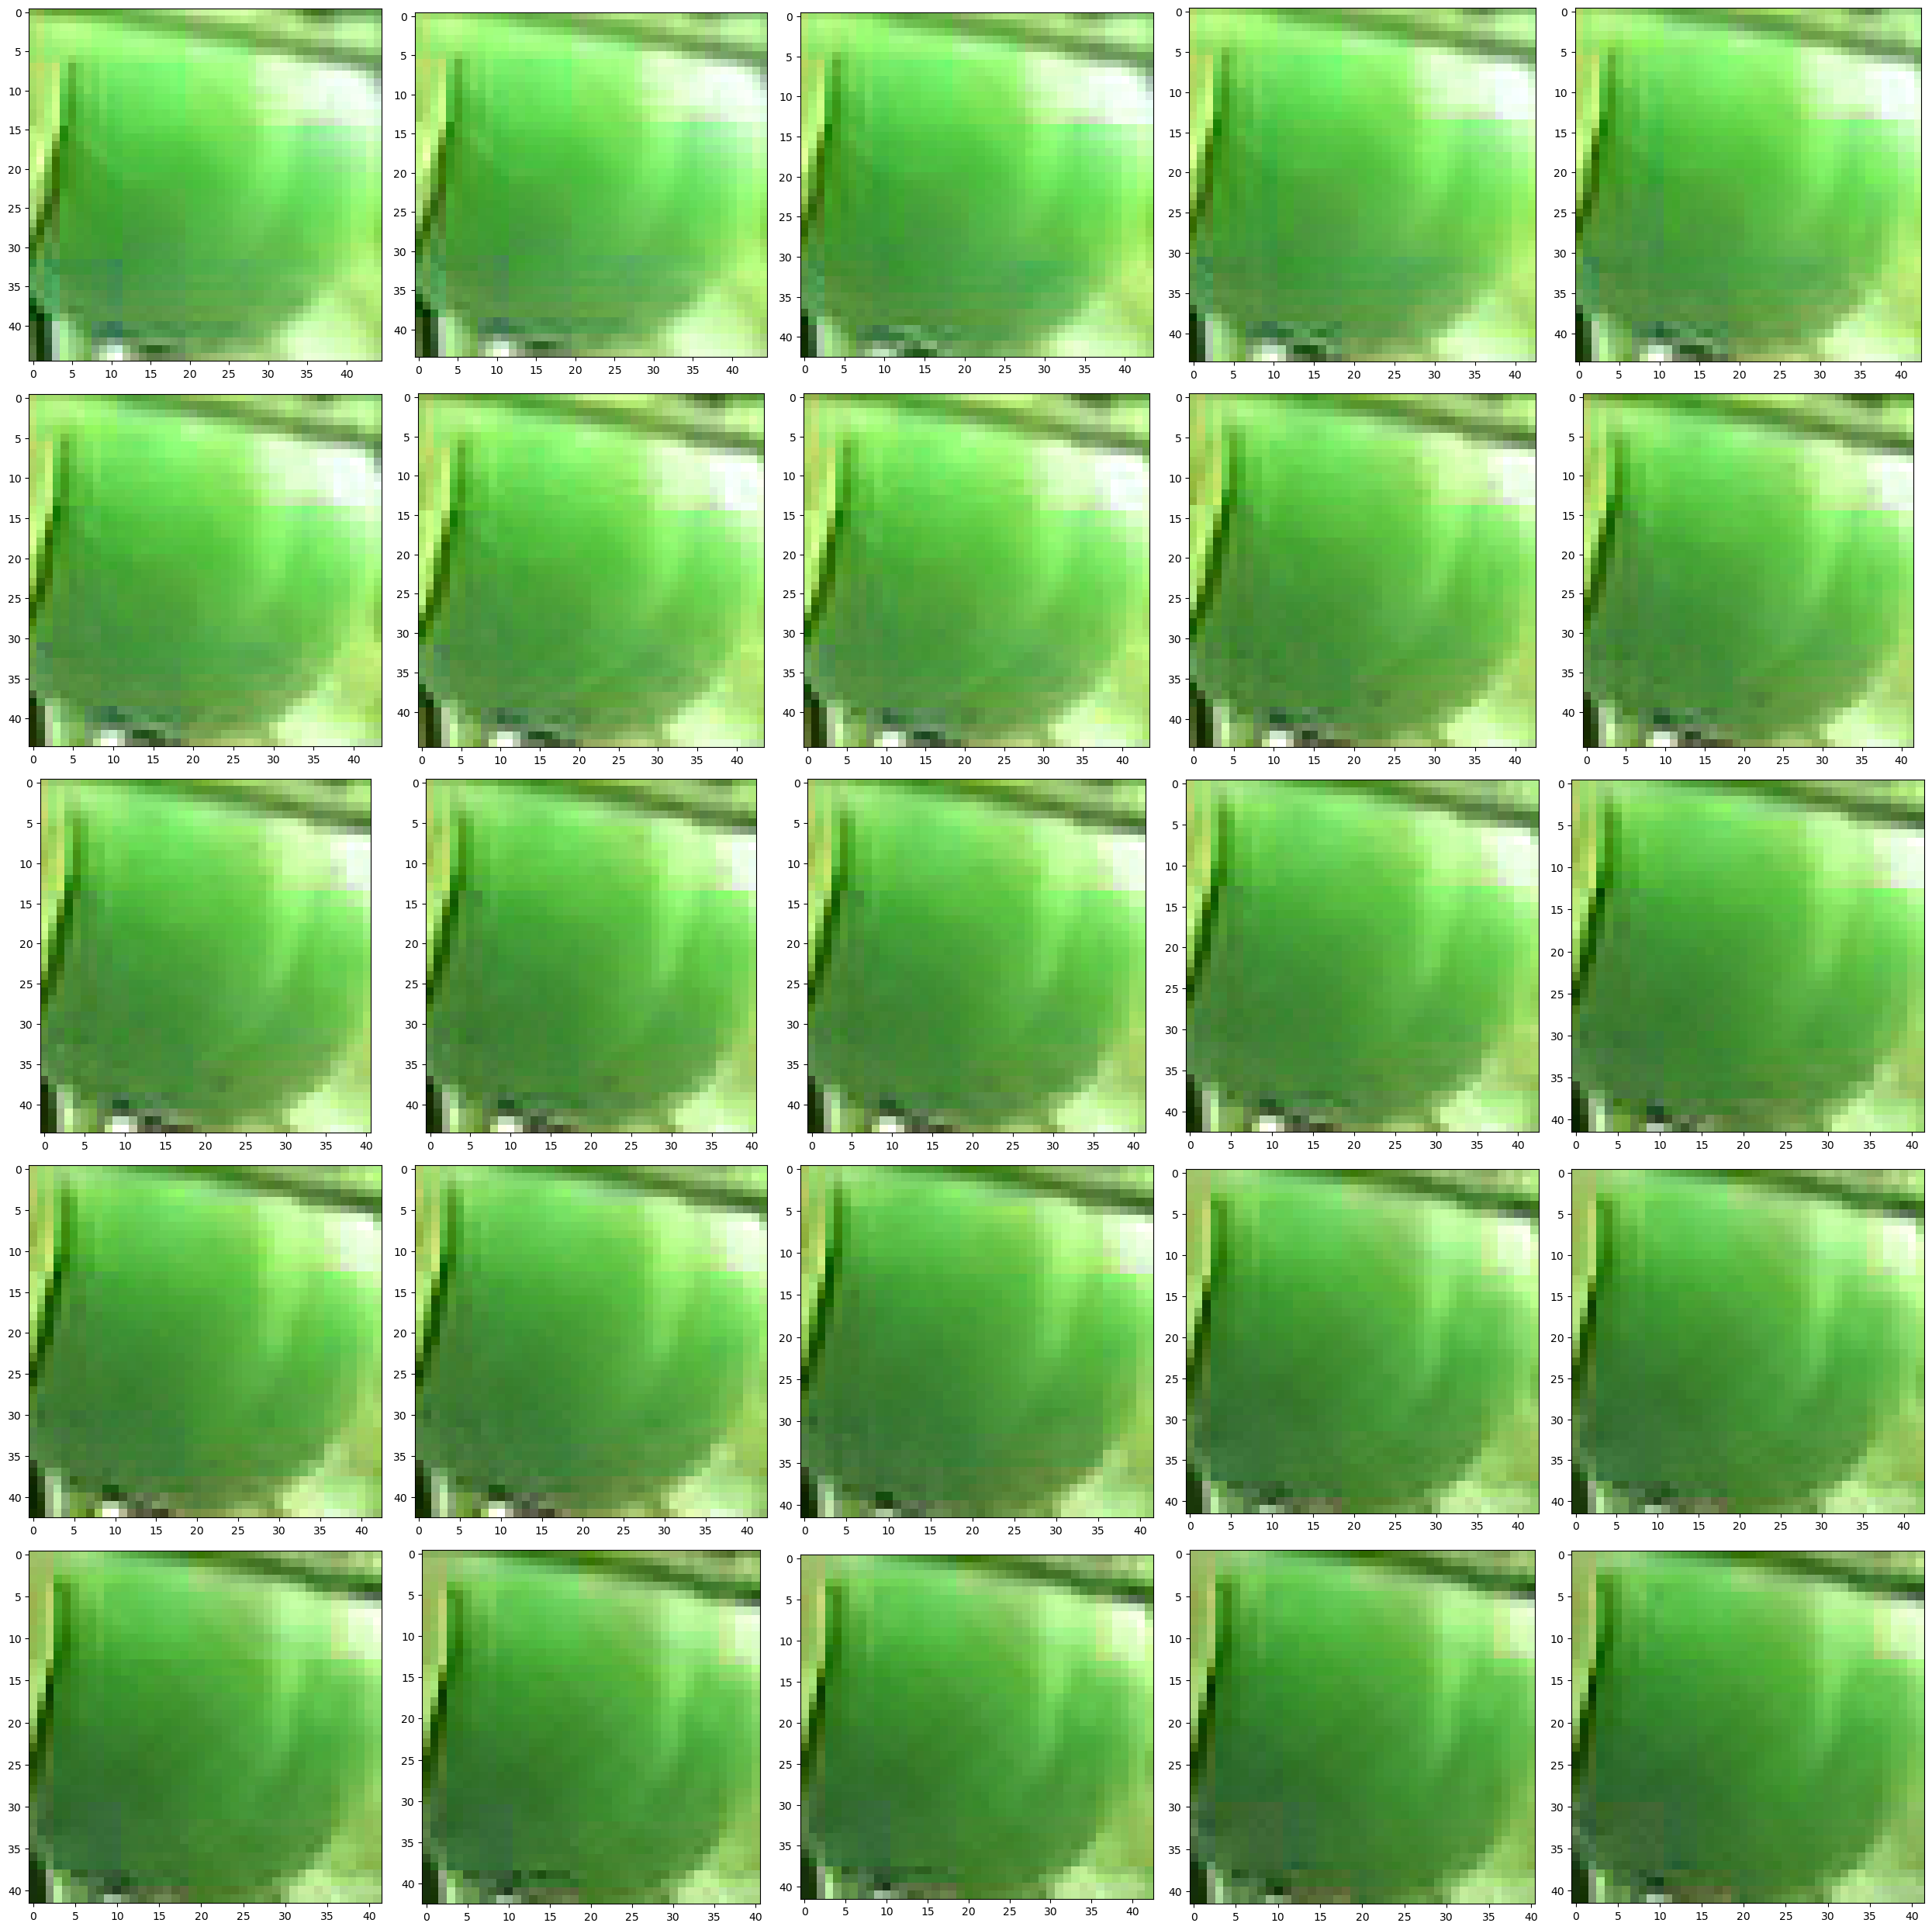

28


11it [00:01,  9.50it/s]


IndexError: list index out of range

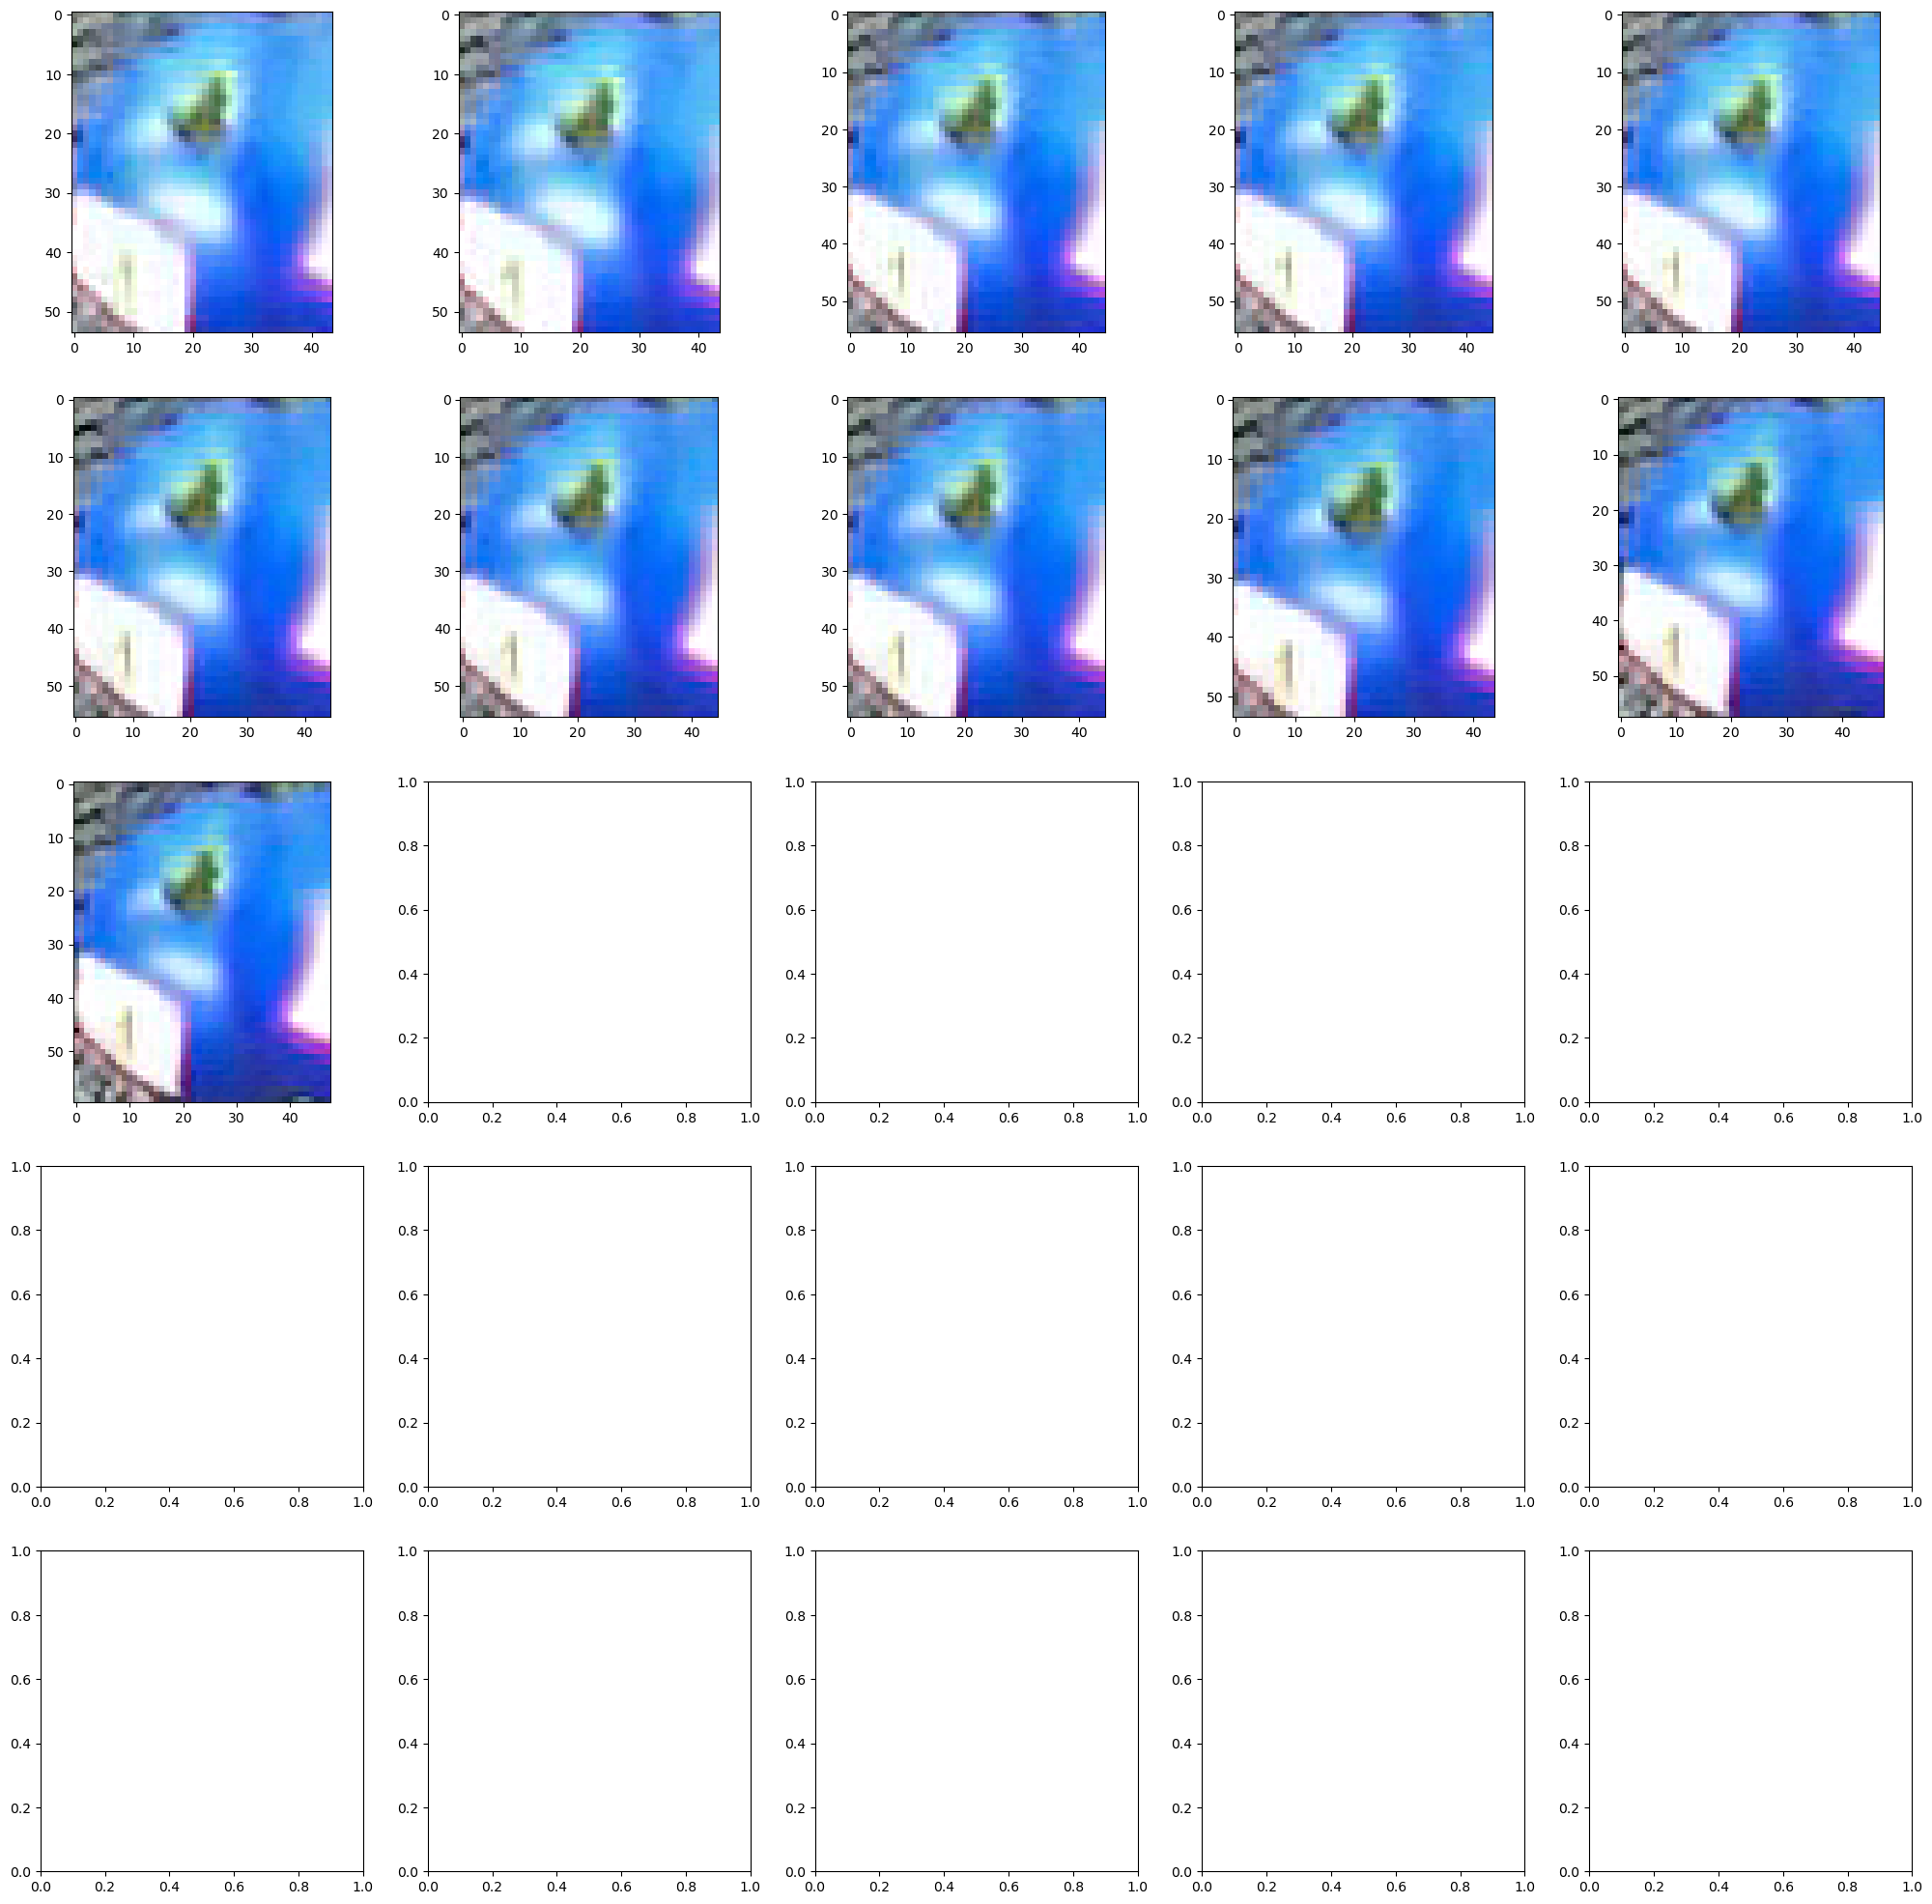

In [20]:
for track_id in [6,7,8,28]:
    print(track_id)
    frame_numbers = get_track_id_frames(measures_frame, track_id)
    boxes = get_track_id_boxes(measures_frame, track_id)
    rgb_images, pc_images = [], []
    for frame, crop in tqdm(zip(frame_numbers, boxes)):
        rgb_img, _, pc_img = cam.get_zed(frame)
        x1,y1,x2,y2 = validate_bbox(crop, rgb_img)
        rgb_images.append(rgb_img[y1:y2,x1:x2])
        pc_images.append(pc_img[y1:y2,x1:x2])
    plot_image_grid(rgb_images,5,5)

In [24]:
pc_images[-1][30,:,0]

array([0.4309327 , 0.38715327, 0.3650185 , 0.3555414 , 0.3529522 ,
       0.35134616, 0.3504534 , 0.3502739 , 0.35012713, 0.3500163 ,
       0.34997287, 0.349925  , 0.3498857 , 0.34985647, 0.3498166 ,
       0.34977815, 0.34974095, 0.34970602, 0.34967908, 0.3496465 ,
       0.34961215, 0.34957102, 0.34947863, 0.3493528 , 0.34920138,
       0.34893295, 0.34854916, 0.34809932, 0.3476534 , 0.3472389 ,
       0.3469223 , 0.3466979 , 0.34652182, 0.34635863, 0.34616217,
       0.34593707, 0.34567496, 0.34532598, 0.34490365, 0.3443212 ,
       0.34366405, 0.34284836, 0.3414092 , 0.33949494, 0.33674932,
       0.3357102 , 0.33549625, 0.33545217], dtype=float32)

In [25]:
pc_images[-1][30,:,1]

array([0.19933687, 0.1780797 , 0.16694978, 0.16169126, 0.15959656,
       0.15795732, 0.15664525, 0.15565477, 0.1546797 , 0.15372115,
       0.15279263, 0.1518624 , 0.1509361 , 0.15001434, 0.14908819,
       0.14816286, 0.14723825, 0.14631478, 0.14539482, 0.14447266,
       0.14354993, 0.14262463, 0.14167877, 0.1407199 , 0.13975146,
       0.13873728, 0.1376789 , 0.13659665, 0.13551824, 0.13445428,
       0.13343018, 0.13244292, 0.13147515, 0.13051318, 0.1295396 ,
       0.1285564 , 0.1275607 , 0.12653452, 0.1254835 , 0.12437681,
       0.12324637, 0.12206291, 0.12066333, 0.11910454, 0.11726621,
       0.11603195, 0.11508618, 0.11419933], dtype=float32)

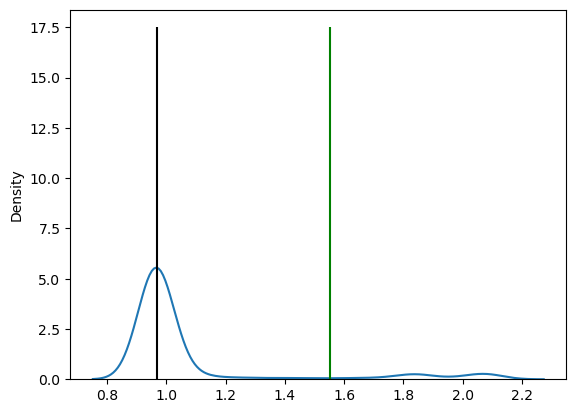

In [36]:
arr = pc_images[-1][:,:,2].flatten()
sns.kdeplot(arr)
plt.vlines(np.nanmedian(arr), 0,17.5,color = "black")
plt.vlines(np.nanmedian(arr) + 2*arr.std(),0,17.5,color = "green")

In [43]:
pc_images[-1][:,:,:3].reshape(-1,3).shape

(2880, 3)

In [ ]:
def plot_3d_cloud(fruit_3d_space, centers, c=None):
    """
    Plot the 3D point cloud of the fruit space
    :param fruit_3d_space: Dictionary containing the 3D coordinates of each fruit
    :param centers: array of the coordinates of each fruit
    :param c: color of the points in the point cloud
    :return: None
    """
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter3D(-centers[:, 2], -centers[:, 0], -centers[:, 1], c=c)
    for i, label in enumerate(fruit_3d_space.keys()):
        ax.text(-centers[i, 2], -centers[i, 0], -centers[i, 1], '%s' % (str(label)), size=10, zorder=1,
                color='k')
    ax.set_xlabel('z')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    ax.view_init(20, 20)
    plt.show()